# Project idea : 
**Help young adults to take care of administrative documents necessary for them**
1. set the requirements
2. explore the tools necessary for the project & put them in a utils file
3. set a .env with API keys


## PLEASE SET YOUR VENV BEFORE RUNNING

In [4]:
# %pip install r- ./requirements.txt 

In [6]:
import os
from dotenv import load_dotenv

# Load environment variables from .env file
if os.path.exists(".env"):
    load_dotenv()
api_key = os.getenv("OPENAI_API_KEY")

In [7]:
from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, HumanMessage

In [8]:
# define our client 
llm_client = ChatOpenAI (model_name = "gpt-5", temperature= 0.0)

In [9]:
import re
import io
import requests
from langchain_core.tools import tool
from typing import Annotated, Sequence, TypedDict, Optional
from typing import Annotated, Optional
import shutil
from pathlib import Path
import json
import PyPDF2

In [10]:
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages

class AgentState(TypedDict): #1 define state 
    messages: Annotated[Sequence[BaseMessage], add_messages]
    system_prompt: SystemMessage

In [11]:
# Create a path where the doc will be loaded from 
UPLOAD_DIRECTORY = Path("./Project_Agentic/") / "uploads"
UPLOAD_DIRECTORY.mkdir(parents=True, exist_ok=True)

In [13]:
def should_continue(state: AgentState) -> str:
    messages = state["messages"]
    last_message = messages[-1]
    # Use getattr with default empty list
    if not getattr(last_message, "tool_calls", []):
        return "end"
    return "continue"



In [14]:
from utils import read_document, upload_document, answer_from_document, list_steps_dynamic, list_steps, analyze_situation, situation, explain_procedures, procedure, fill_template_interactive, fill_template, text_to_pdf_dynamic, text_to_pdf

In [15]:
# bind the tools 
tools_doc = [read_document, upload_document, answer_from_document]
llm_with_tools_doc = llm_client.bind_tools(tools_doc)

tools_doc_by_name = {tool_doc.name: tool_doc for tool_doc in tools_doc}
tools_doc_by_name

{'read_document': StructuredTool(name='read_document', description='Read the document', args_schema=<class 'langchain_core.utils.pydantic.read_document'>, func=<function read_document at 0x0000013AB2E86DE0>),
 'upload_document': StructuredTool(name='upload_document', description='upload the document', args_schema=<class 'langchain_core.utils.pydantic.upload_document'>, func=<function upload_document at 0x0000013AB2E86AC0>),
 'answer_from_document': StructuredTool(name='answer_from_document', description='generate an answer with information given from the document', args_schema=<class 'langchain_core.utils.pydantic.answer_from_document'>, func=<function answer_from_document at 0x0000013AB2E86E80>)}

In [16]:
tools_step = [list_steps]
llm_with_tools_step = llm_client.bind_tools(tools_step)

tools_step_by_name = {tool_step.name: tool_step for tool_step in tools_step}
tools_step_by_name

{'list_steps': StructuredTool(name='list_steps', description='list all of the steps needed', args_schema=<class 'langchain_core.utils.pydantic.list_steps'>, func=<function list_steps at 0x0000013AB2E87880>)}

In [17]:
# tools_procedure = [procedure]
# llm_with_tools_procedure = llm_client.bind_tools(tools_procedure)

# tools_procedure_by_name = {tool_procedure.name: tool_procedure for tool_procedure in tools_procedure}
# tools_procedure_by_name

In [18]:
tools_situation = [situation]
llm_bind_with_tools_situation = llm_client.bind_tools(tools_situation)

tools_situation_by_name = {tool_situation.name: tool_situation for tool_situation in tools_situation}
tools_situation_by_name

{'situation': StructuredTool(name='situation', description='Give a summary of the situation of the user then provide a solution', args_schema=<class 'langchain_core.utils.pydantic.situation'>, func=<function situation at 0x0000013AB2E87100>)}

In [19]:
tools_template = [fill_template]
llm_bind_with_tools_temp = llm_client.bind_tools(tools_template)

tools_temp_by_name = {tool_template.name: tool_template for tool_template in tools_template}
tools_temp_by_name

{'fill_template': StructuredTool(name='fill_template', description='Fill a template and save it as a TXT file.\nReturns the path to the generated TXT file.', args_schema=<class 'langchain_core.utils.pydantic.fill_template'>, func=<function fill_template at 0x0000013AB2E87920>)}

In [20]:
tools_pdf = [text_to_pdf]
llm_bind_with_tools_pdf = llm_client.bind_tools(tools_pdf)

tools_pdf_by_name = {tool_pdf.name: tool_pdf for tool_pdf in tools_pdf}
tools_pdf_by_name

{'text_to_pdf': StructuredTool(name='text_to_pdf', description='Convert a TXT file to a PDF.', args_schema=<class 'langchain_core.utils.pydantic.text_to_pdf'>, func=<function text_to_pdf at 0x0000013AB2E87BA0>)}

In [21]:
from langchain_core.messages import ToolMessage
from langchain_core.runnables import RunnableConfig

# tool node
def tools_doc_node(state: AgentState) -> AgentState:
    outputs = []
    last_message = state["messages"][-1]

    for tool_call in last_message.tool_calls:
        # handle both dict-style and attribute-style tool calls
        tool_args = (
            tool_call.get("args", {}) 
            if isinstance(tool_call, dict) 
            else tool_call.args
        )

        tool_result = tools_doc_by_name[tool_call["name"]](tool_args)

        outputs.append(
            ToolMessage(
                content=tool_result,
                name=tool_call["name"],
                tool_call_id=tool_call["id"],
            )
        )

    return {"messages": outputs}

def tools_step_node(state: AgentState) -> AgentState:
    outputs = []
    last_message = state["messages"][-1]

    for tool_call in last_message.tool_calls:
        # handle both dict-style and attribute-style tool calls
        tool_args = (
            tool_call.get("args", {}) 
            if isinstance(tool_call, dict) 
            else tool_call.args
        )

        tool_result = tools_step_by_name[tool_call["name"]](tool_args)

        outputs.append(
            ToolMessage(
                content=tool_result,
                name=tool_call["name"],
                tool_call_id=tool_call["id"],
            )
        )

    return {"messages": outputs}

# def tools_procedure_node(state: AgentState) -> AgentState:
#     outputs = []
#     last_message = state["messages"][-1]

#     for tool_call in last_message.tool_calls:
#         # handle both dict-style and attribute-style tool calls
#         tool_args = (
#             tool_call.get("args", {}) 
#             if isinstance(tool_call, dict) 
#             else tool_call.args
#         )

#         tool_result = tools_procedure_by_name[tool_call["name"]](tool_args)

#         outputs.append(
#             ToolMessage(
#                 content=tool_result,
#                 name=tool_call["name"],
#                 tool_call_id=tool_call["id"],
#             )
#         )


def tools_situation_node(state: AgentState) -> AgentState:
    outputs = []
    last_message = state["messages"][-1]

    for tool_call in last_message.tool_calls:
        # handle both dict-style and attribute-style tool calls
        tool_args = (
            tool_call.get("args", {}) 
            if isinstance(tool_call, dict) 
            else tool_call.args
        )

        tool_result = tools_situation_by_name[tool_call["name"]](tool_args)

        outputs.append(
            ToolMessage(
                content=tool_result,
                name=tool_call["name"],
                tool_call_id=tool_call["id"],
            )
        )

def tools_template_node(state: AgentState) -> AgentState:
    outputs = []
    last_message = state["messages"][-1]

    for tool_call in last_message.tool_calls:
        # handle both dict-style and attribute-style tool calls
        tool_args = (
            tool_call.get("args", {}) 
            if isinstance(tool_call, dict) 
            else tool_call.args
        )

        tool_result = tools_temp_by_name[tool_call["name"]](tool_args)

        outputs.append(
            ToolMessage(
                content=tool_result,
                name=tool_call["name"],
                tool_call_id=tool_call["id"],
            )
        )

def tools_pdf_node(state: AgentState) -> AgentState:
    outputs = []
    last_message = state["messages"][-1]

    for tool_call in last_message.tool_calls:
        # handle both dict-style and attribute-style tool calls
        tool_args = (
            tool_call.get("args", {}) 
            if isinstance(tool_call, dict) 
            else tool_call.args
        )

        tool_result = tools_pdf_by_name[tool_call["name"]](tool_args)

        outputs.append(
            ToolMessage(
                content=tool_result,
                name=tool_call["name"],
                tool_call_id=tool_call["id"],
            )
        )

# node that calls the llm model // State evolves while going from a node to another 
def call_llm_node(state: AgentState,
                  config: RunnableConfig) -> AgentState:

    response = llm_with_tools_doc.invoke(
    {"messages": [state["system_prompt"]] + state["messages"]},
    config=config) #node makes call to llm
    # We return a list, because this will get added to the exisitng list of messages
    return {"messages": [response]}



# if loop : condition edge that determines whether to continue or not
def should_continue(state: AgentState) -> str:
    messages = state["messages"]
    last_message = messages[-1]
    if not last_message.tool_calls:
        return "end"
    else: 
        return "continue"

In [22]:
from langgraph.graph import StateGraph, START, END

# Graph
workflow = StateGraph(AgentState) 

# Define the two nodes we will cycle between
workflow.add_node("llm", call_llm_node)  #llm
workflow.add_node("tool doc", tools_doc_node)   #doc
workflow.add_node("tool steps", tools_step_node)  #steps
workflow.add_node("tool situation", tools_situation_node)   #situation
# workflow.add_node("tool procedures", tools_procedure_node)   #procedures
workflow.add_node("tool template", tools_template_node)    #template
workflow.add_node("tool pdf", tools_pdf_node)

workflow.add_edge(START, "llm")
workflow.add_edge("llm", "tool doc")

# loop
workflow.add_conditional_edges(  
    "tool doc", 
    
    should_continue,
    {
        # If `tools`, then call the tool node.
        "continue": "tool steps", 
        },
    )
# Finally, we need to add an edge from tool back to agent
workflow.add_edge("tool steps", "tool doc")


workflow.add_edge("tool steps", "tool situation")
workflow.add_edge("tool situation", "tool template")
workflow.add_edge("tool template", "tool pdf")
workflow.add_edge("tool pdf", END)

graph = workflow.compile()

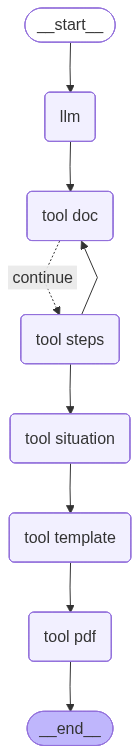

In [23]:
display(graph)